# Motivation
This notebook analyses the spreadsheet containing information on the reversals. This spreadsheet collects different features on the trades in an attempt of creating a binary classifier, this classifier will learn from the data collected and will predict the value of the `outcome` variable, which can be success of failre

# Data
The data has been collected in an spreadsheet containing trades both simulated and real. And the different trades have been classified into three types: continuation, counter and ranging. The independent variables gathered for each trade type are:
## Continuation trades
* id	id used in the screenshot folder to identify this record
* start	start of this trade
* timeframe	in the format 2D,D,H12,H8
* entry	price
* outcome	S=success;F=failure;B=breakeven
* ext_outcome. S=success;F=failure;B=breakeven
* RSI bounces. number of RSI bounces ocurring in the trend before entry
* No of candles. How many candles before occurred the bounce, from the entry of trade to the first bounce (without counting the entry candle)
* entry on RSI. Was the entry candle on RSI?
* length of trend. lenght of the preceding trend in number of candles. The valley before the continuation is not included in the count
* previous swings. Number of swings from the entry and counting the rebound before the entry (see screenshot below)
* space interswings. Comma separated numbers representing the number of candles between swings from the most recent to the oldest
* length in pips. From the beginning of the trade to the entry price in number of pips
strong trend	TRUE of the preceding trend was strong
* trend angle. Measured with Oanda after hitting the auto scale button+lock scalde button and the end of the trend line is the IC+1 when it touches the entry price
* bounce length. Length in number of candles for each of the bounces (in the order from the most recent to the oldest)
* bounce pips. Length from the horizontal line defined by IC until the highest point of the bounce (considering wicks also)
* inn_bounce. Number of candles of the inner bounce (see screenshots below)
indecission	Number of candles the price stays in S/R, without considering the bounce and only considering the candles pre/post bounce
* retraced.	Only relevant for outcome=F, how many pips from the S/L the trade reversed?. If n.a., then it means that the trade did not reversed last time that the price was below/above this level assuming that a possible counter could happen
* entry_aligned. Is the entry aligned with previous bounces on the same trend. TRUE or 1 if it is, FALSE or 0 if it is not

## Dependencies

In [669]:
import pandas as pd
import numpy as np
import pdb
import re
import seaborn as sns
from pandas.plotting import scatter_matrix
from sklearn.metrics import confusion_matrix,precision_score
from sklearn.model_selection import train_test_split

%matplotlib inline

# Continuation trades

First, let's create a function to read-in a .csv file containing the data andstore it in a dataframe:

In [670]:
def read_tradedata(tradefile,sep,na_values):
    '''
    Parameters
    ----------
    tradefile : str, required
                Path to file containing the trade data
    sep : str, optionsl
          Field separator used in the file. i.e. ',' (comma separated values), '\t' (tab-separated values)
    na_values : list, optional
                Additional list of strings to recognize as NA/NaN. i.e. ['n.a.']
    
    Returns
    -------
    A Pandas dataframe
    '''
    DF=pd.read_csv(tradefile,sep=sep,na_values=na_values)
    
    return DF

contDF=read_tradedata('/Users/ernesto/Downloads/Screenshot analysis - continuations.csv',sep=",",na_values=["n.a.","n.a"])

contDF.shape

(181, 23)

And some information about contDF:

In [671]:
contDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 181 entries, 0 to 180
Data columns (total 23 columns):
id                         181 non-null object
start                      181 non-null object
timeframe                  181 non-null object
entry                      181 non-null float64
outcome                    181 non-null object
ext_outcome                181 non-null object
RSI bounces                181 non-null int64
bounce length              150 non-null object
bounce (pips)              181 non-null int64
inn_bounce                 181 non-null int64
entry on RSI               181 non-null bool
length of trend            181 non-null int64
strong trend               181 non-null bool
last time                  151 non-null object
indecission                151 non-null float64
Candle +1 against trade    151 non-null object
No of candles              120 non-null float64
previous swings            151 non-null float64
space interswings          151 non-null object
length

* Conversion to right types<br>
Let's convert now the `start` and `last time` variables to DateTime

In [672]:
contDF['start']= pd.to_datetime(contDF['start'])
contDF['last time']= pd.to_datetime(contDF['last time'])

## Cleaning the n.a. values
The following predictors have n.a. values and the strategy I will follow will depend on each case:

* No of candles (will replace the n.a. by 0)

In [673]:
contDF["No of candles"].fillna(0, inplace=True)

* Bounce length (will replace the n.a. by 0)

In [674]:
contDF["bounce length"].fillna(0, inplace=True)

## Transforming

In [675]:
transl_dict={ 
        'S':1,
        'F':0, 
        True:1, 
        False:0
    }
def digit_binary(x,transl_dict,name):
    '''
    This function will replace the values in categorical
    binary variables by 1 and 0
    
    Parameters
    ----------
    transl_dict: dict
                 Keys will be the old categorical names and Values
                 will be 1 and 0. For example:
                 transl_dict={ 
                            'S':1,
                            'F':0, 
                            True:1, 
                            False:0
                            }
    name: str
          Name of the column to modify
        
    Returns
    -------
    The new label for the categorical variable
    '''
    
    return transl_dict[x[name]]

contDF['ext_outcome']=contDF.apply(digit_binary,axis=1,transl_dict=transl_dict, name='ext_outcome')
contDF['entry on RSI']=contDF.apply(digit_binary,axis=1,transl_dict=transl_dict, name='entry on RSI')
contDF['strong trend']=contDF.apply(digit_binary,axis=1,transl_dict=transl_dict, name='strong trend')

## Initial exploration of the data

First things first, let's examine if we have a significant number of records per category of the dependent variable (outcome in this case), since it is really very important to have enough records to establish solid conclusions

In [676]:
outcome_ix=5 # 4=outcome and 5= ext_outcome
outcome_lab="ext_outcome"
contDF.iloc[:,outcome_ix].value_counts()

1    95
0    86
Name: ext_outcome, dtype: int64

For now I am not going to consider the trades having an outcome of 'B'. So, let's remove them from the dataframe:

In [677]:
contDF=contDF[contDF.outcome != 'B']

###  RSI bounces
Let's examine if there is a correlation between the number of bounces and the outcome of the trade

As an initial exploration I will create a boxplot displaying the data

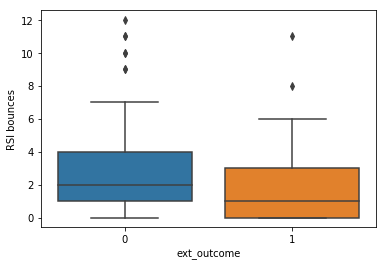

In [678]:
ax = sns.boxplot(x=outcome_lab, y="RSI bounces", data=contDF)

* Mean for each category

In [679]:
contDF.groupby(outcome_lab).agg({'RSI bounces': 'mean'})

,RSI bounces
ext_outcome,
0,2.755814
1,1.800000


* Median for each category

In [680]:
medianBounce=contDF.groupby(outcome_lab).agg({'RSI bounces': 'median'})
print(medianBounce)

             RSI bounces
ext_outcome             
0                      2
1                      1


* Conclusion <br>
The median number of bounces for successful trades is {{'%.0f' % medianBounce.iloc[1,0]}}<br>
The median number of bounces for failed trades is {{'%.0f' % medianBounce.iloc[0,0]}}<br>

* Distribution of the number of bounces<br>
For this particular task I will create a count plot in order to plot the RSI bounces for both the successful and the failed trades

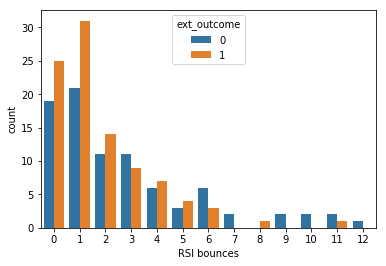

In [681]:
ax = sns.countplot(x="RSI bounces",hue=outcome_lab, data=contDF)

Now, let's calculate the normalized number of bounces, as the 2 categories of the outcome variables are imbalanced

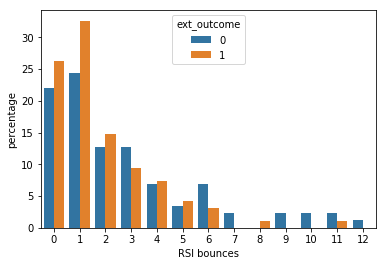

In [682]:
contDF_counts = (contDF.groupby([outcome_lab])['RSI bounces']
                  .value_counts(normalize=True)
                  .rename('percentage')
                  .mul(100)
                  .reset_index()
                  .sort_values('RSI bounces'))

p = sns.barplot(x="RSI bounces", y="percentage", hue=outcome_lab, data=contDF_counts)

* Conclusion<br>
The ideal situation for having a S trade is to have either 1 or 2 bounces

### No of candles
This variable represents the number of candles since the beginning of the trade until the first RSI bounce. I am going compare the distribution of this variable depending on the `outcome` variable.<br>

As an initial exploration I will create a boxplot displaying the data:

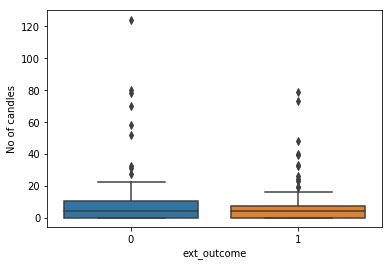

In [683]:
ax = sns.boxplot(x=outcome_lab, y="No of candles", data=contDF)

* Mean for each category

In [684]:
contDF.groupby(outcome_lab).agg({'No of candles': 'mean'})

,No of candles
ext_outcome,
0,10.488372
1,7.642105


* Median for each category

In [685]:
contDF.groupby(outcome_lab).agg({'No of candles': 'median'})

,No of candles
ext_outcome,
0,4.0
1,4.0


Let's analyze the distribution with a histogram

array([<matplotlib.axes._subplots.AxesSubplot object at 0x12359e9b0>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x123edae48>], dtype=object)

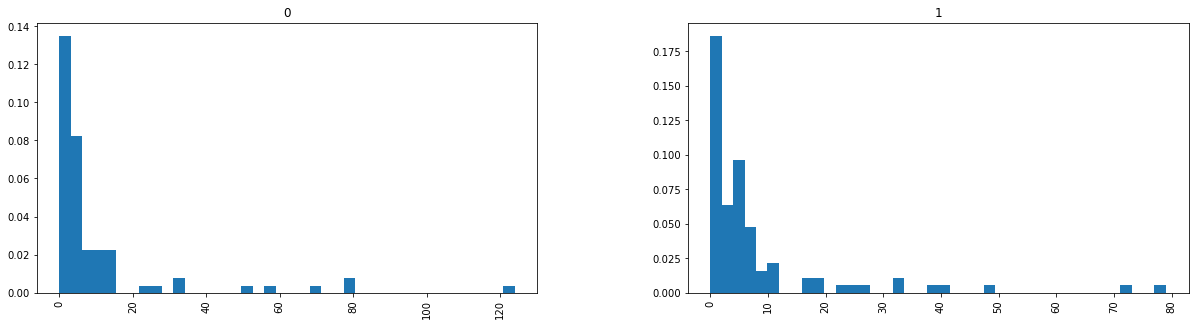

In [686]:
contDF['No of candles'].hist(by=contDF[outcome_lab],figsize=(20,5),bins=40,normed=True)

### entry on RSI
This boolean variable will be True if the entry of the trade is in oversold/overbought RSI
Firs, let's see the counts for each category of the variable

In [687]:
contDF['entry on RSI'].value_counts()

0    142
1     39
Name: entry on RSI, dtype: int64

Let's compare the proportions for this variable between the 2 categories of the `outcome` variable

In [688]:
div_class=pd.crosstab(contDF.iloc[:,outcome_ix], contDF['entry on RSI'],margins=True)
print(div_class)

entry on RSI    0   1  All
ext_outcome               
0              71  15   86
1              71  24   95
All           142  39  181


It's is easier to visualize the relationship if we calculate the percentages:

In [689]:
prop=(div_class/div_class.loc["All"])*100
print(prop)

entry on RSI      0           1         All
ext_outcome                                
0              50.0   38.461538   47.513812
1              50.0   61.538462   52.486188
All           100.0  100.000000  100.000000


* Conclusion <br>
Within the trades having entry on RSI there are {{'%.1f' % prop.iloc[0, 1]}}% of failures and {{'%.1f' % prop.iloc[1, 1]}}% of successes<br>
Within the trades not having an entry on RSI there are {{'%.1f' % prop.iloc[0, 0]}}% of failures and {{'%.1f' % prop.iloc[1, 0]}}% of successes

### length of trend
This quantitative discrete variable measures the length of the trade measured in term of the number of candles. Let's start comparing the distribution of this variable for the different categories of the `outcome` variable

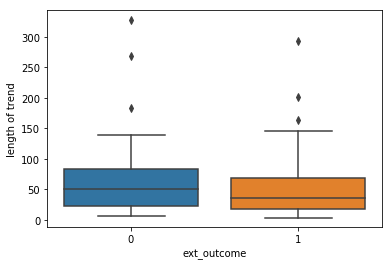

In [690]:
ax = sns.boxplot(x=outcome_lab, y="length of trend", data=contDF)

(0, 100)

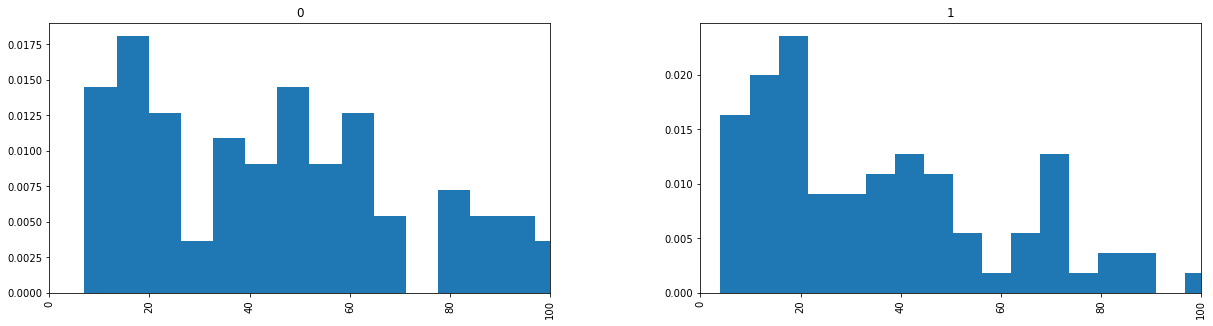

In [691]:
axList=contDF['length of trend'].hist(by=contDF[outcome_lab],figsize=(20,5),bins=50,normed=True)

axList[0].set_xlim((0,100))
axList[1].set_xlim((0,100))

* Mean for each category

In [692]:
contDF.groupby(outcome_lab).agg({'length of trend': 'mean'})

,length of trend
ext_outcome,
0,61.360465
1,50.578947


* Median for each category

In [693]:
contDF.groupby(outcome_lab).agg({'length of trend': 'median'})

,length of trend
ext_outcome,
0,50
1,36


* Analysis of trades by a certain trend length cutoff

In [694]:
short_lengths=contDF.loc[(contDF['length of trend']>=0) & (contDF['length of trend'] <=10)]
print(short_lengths)

                       id               start timeframe      entry outcome  \
7      AUD_USD 17SEP2013D 2013-09-17 23:00:00         D    0.93555       S   
21   EUR_USD 23JAN2012H12 2012-01-23 10:00:00       H12    1.29515       S   
29   GBP_AUD 17SEP2014H12 2014-09-17 10:00:00       H12    1.80123       S   
32   GBP_AUD 30OCT2017H12 2017-10-30 09:00:00       H12    1.71750       S   
33   USD_CHF 10AUG2007H12 2007-10-08 10:00:00       H12    1.19949       S   
63     USD_JPY 06DEC2007D 2007-06-12 23:00:00         D  111.06400       S   
94   EUR_GBP 15FEB2009H12 2009-02-15 22:00:00       H12    0.89884       F   
156   NZD_JPY 11032010H12 2010-11-03 22:00:00       H12   63.54100       S   
157  NZD_JPY 05NOV2010H12 2010-05-11 09:00:00       H12   64.35100       F   
159  NZD_JPY 06DEC2011H12 2011-06-12 22:00:00       H12   60.75700       F   
176  GBP_JPY 15SEP2009H12 2015-09-15 22:00:00       H12  185.05700       S   
178  GBP_JPY 26JAN2016H12 2016-01-26 10:00:00       H12  168.853

In [695]:
short_lengths[outcome_lab].value_counts()

1    9
0    3
Name: ext_outcome, dtype: int64

### inn_bounce
Integer variable representing the number of candles of the inner bounce. Let's start comparing the distribution of this variable for the different categories of the `outcome` variable

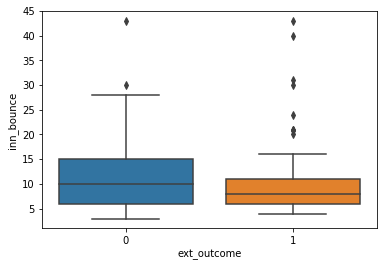

In [696]:
ax = sns.boxplot(x=outcome_lab, y="inn_bounce", data=contDF)

* Mean for each category

In [697]:
contDF.groupby(outcome_lab).agg({'inn_bounce': 'mean'})

,inn_bounce
ext_outcome,
0,11.779070
1,9.768421


* Median for each category

In [698]:
contDF.groupby(outcome_lab).agg({'inn_bounce': 'median'})

,inn_bounce
ext_outcome,
0,10
1,8


* Histogram

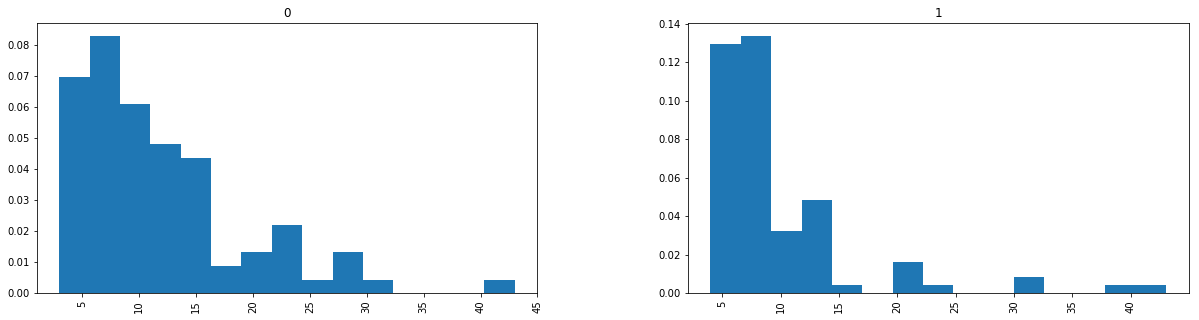

In [699]:
axList=contDF['inn_bounce'].hist(by=contDF[outcome_lab],figsize=(20,5),bins=15,normed=True)

### Strong trend
Boolean that is TRUE when trend is strong, FALSE otherwise.

Let's compare the proportions for this variable between the 2 categories of the `outcome` variable

In [700]:
div_class=pd.crosstab(contDF.iloc[:,outcome_ix], contDF['strong trend'],margins=True)
print(div_class)

strong trend   0   1  All
ext_outcome              
0             46  40   86
1             42  53   95
All           88  93  181


It's is easier to visualize the relationship if we calculate the percentages:

In [701]:
propStrength=(div_class/div_class.loc["All"])*100
print(propStrength)

strong trend           0           1         All
ext_outcome                                     
0              52.272727   43.010753   47.513812
1              47.727273   56.989247   52.486188
All           100.000000  100.000000  100.000000


* Conclusion <br>
Within the trades trending strongly there are {{'%.1f' % propStrength.iloc[0, 1]}}% of failures and {{'%.1f' % propStrength.iloc[1, 1]}}% of successes<br>
Within the trades not trending strongly there are {{'%.1f' % propStrength.iloc[0, 0]}}% of failures and {{'%.1f' % propStrength.iloc[1, 0]}}% of successes

### bounce length
This variable is a comma separated list of integers representing how wide (in number of candles) each of the RSI bounces is. This variable requires a little bit of preprocessing, and I will write a function that calculates the total length (in number of candles) by adding the length of each of the bounces

In [702]:
def sum_lengths(x):
    '''
    Function to calculate the sum (in number of candles)
    of all the RSI bounces
    
    Parameters
    ----------
    x = string with a comma separated list of numbers
        i.e. 1,4,2,3
        
    Returns
    -------
    An integer representing the total bounce length
    '''
    
    return sum([int(i) for i in x.split(",")])
    

And I will apply the `sum_lengths` function and put the results in a new column named `sum_bounces`

In [703]:
contDF['sum_bounces']=contDF['bounce length'].astype(str).apply(sum_lengths)

Now, I will plot the distribution of this new variable on each `outcome`category:

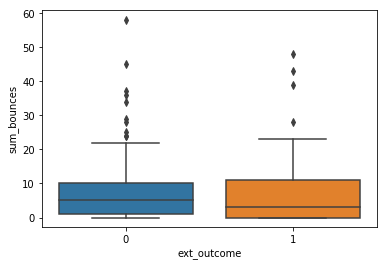

In [704]:
ax = sns.boxplot(x=outcome_lab, y="sum_bounces", data=contDF)

* Mean for each category

In [705]:
contDF.groupby(outcome_lab).agg({'sum_bounces': 'mean'})

,sum_bounces
ext_outcome,
0,8.488372
1,6.968421


* Median for each category

In [706]:
contDF.groupby(outcome_lab).agg({'sum_bounces': 'median'})

,sum_bounces
ext_outcome,
0,5
1,3


* Histogram

(0, 25)

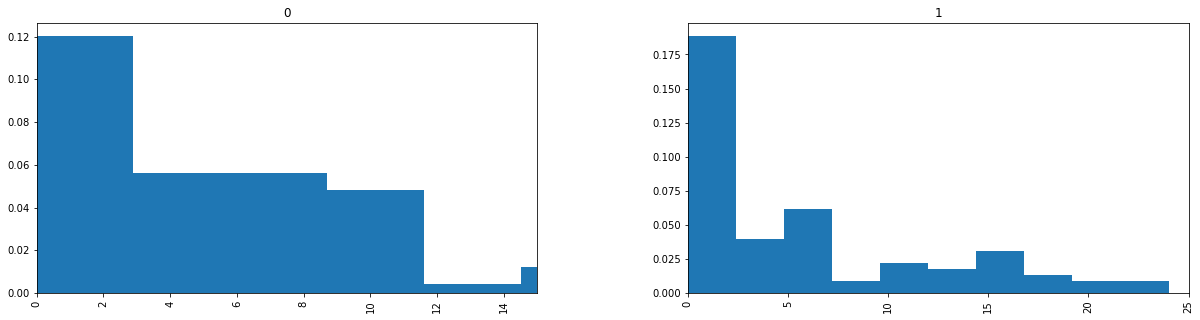

In [707]:
axList=contDF['sum_bounces'].hist(by=contDF[outcome_lab],figsize=(20,5),bins=20,normed=True)

axList[0].set_xlim((0,15))
axList[1].set_xlim((0,25))

### bounce (pips)
This quantitative variable represents the length from the horizontal line defined by IC until the highest point of the bounce (considering wicks also).  Let's start comparing the distribution of this variable for the different categories of the `outcome` variable

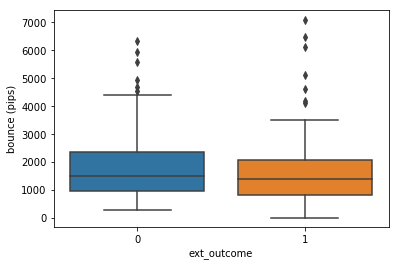

In [708]:
ax = sns.boxplot(x=outcome_lab, y="bounce (pips)", data=contDF)

* Mean for each category

In [709]:
contDF.groupby(outcome_lab).agg({'bounce (pips)': 'mean'})

,bounce (pips)
ext_outcome,
0,1881.686047
1,1665.863158


* Median for each category

In [710]:
contDF.groupby(outcome_lab).agg({'bounce (pips)': 'median'})

,bounce (pips)
ext_outcome,
0,1485
1,1385


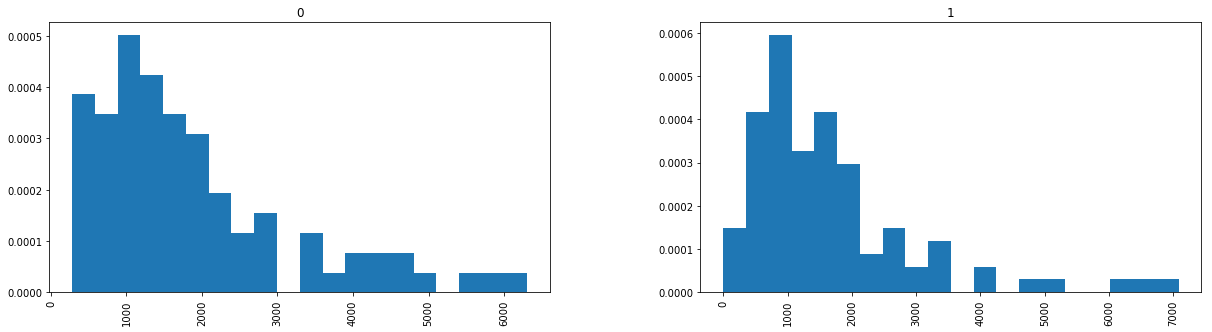

In [711]:
axList=contDF['bounce (pips)'].hist(by=contDF[outcome_lab],figsize=(20,5),bins=20,normed=True)

#axList[0].set_xlim((0,3000))
#axList[1].set_xlim((0,3000))

### entry_aligned
Is the entry aligned with previous bounces on the same trend. TRUE or 1 if it is, FALSE or 0 if it is not

Let's compare the proportions for this variable between the 2 categories of the `outcome` variable

In [712]:
div_class=pd.crosstab(contDF.iloc[:,outcome_ix], contDF['entry_aligned'],margins=True)
print(div_class)

entry_aligned   0   1  All
ext_outcome               
0              66  20   86
1              32  63   95
All            98  83  181


It's is easier to visualize the relationship if we calculate the percentages:

In [713]:
propStrength=(div_class/div_class.loc["All"])*100
print(propStrength)

entry_aligned           0           1         All
ext_outcome                                      
0               67.346939   24.096386   47.513812
1               32.653061   75.903614   52.486188
All            100.000000  100.000000  100.000000


* Conclusion <br>
There is a clear relationship between succesful trades and `entry_aligned=1`

## Conclusions

This section collects all the conclusions derived from the first exploration of the data. It shows the variable that are relevant and irrelevant for the fate of the continuation trades.<br>
* Relevant:<br>
1) Candle +1 against trade <br>
Within the trades with IC+1 against the trade there are {{'%.1f' % propCp1.iloc[0, 1]}}% of failures and {{'%.1f' % propCp1.iloc[1, 1]}}% of successes<br>
Within the trades with IC+1 in favour of the trade there are {{'%.1f' % propCp1.iloc[0, 0]}}% of failures and {{'%.1f' % propCp1.iloc[1, 0]}}% of successes<br>
2) RSI bounces <br>
The median number of bounces for successful trades is {{'%.0f' % medianBounce.iloc[1,0]}}<br>
The median number of bounces for failed trades is {{'%.0f' % medianBounce.iloc[0,0]}}<br>
The ideal situation for having a S trade is to have either 1 or 2 bounces<br>
3) No of candles <br>
The median number of candles for S is 4 and for F is 5<br>
5) Length of the trend <br>
The median length of the trade for S trades (50) is lower than for F trades (66). Also, after inspecting the distribution, we see that the majority of S trades have a length ranging from [15-60]<br>
6) inn_bounce <br>
The signal is strong. The bounces are smaller for S trades.
cutoff-> trades having >12<br>
7) indecission <br>
Signal is weak. The number of candles in indecission is smaller in S trades
cutoff-> trades having >6<br>
8) bounce (ratio) <br>
Signal is weak. The ratio inn_bounce/indecission is slightly higher for `S` trades<br>
8) Strong trend<br>
Signal is strong. The trend is stronger in S trades<br>
9) bounce length<br>
Signal is strong. The median bounce length is smaller in S trades
cutoff--> trades having a length > 12<br>
10) bounce (pips)<br>
Signal is strong. The median length in pips for the bounce is smaller in S trades
* Irrelevant:<br>

1) trend angle<br>
No significative differences between S and F trades<br>
2) last time <br>
No significative differences between S and F trades<br>
3) length in pips (norm) <br>
No significative differences between S and F trades<br>
4) previous swings <br>
No significative difference between S and F trades in terms of the number of previous swings from the entry
5) entry on RSI <br>
No significative differences between S and F trades<br>

## Calculating points
This section will calculate a total score for each trade that will be used to predict the outcome.<br>

### Splitting the data into training and test sets
Let's split the data into training and test sets. We are going to use a test set size of 0.33

In [714]:
train, test = train_test_split(contDF,
                               test_size=0.33
                              )

First, let's create a function to calculate the points

In [715]:
def calculate_points(row,attribs):
    '''
    Function to calculate the points for a particular trade
    
    Parameters
    ----------
    row : dataframe row
    attribs : list of dicts
              The dict has the following format:
              {'attr' : 'RSI bounces',
               'cutoff' : 3,
               'points' : 2}
               
    Returns
    -------
    Returns a score for this trade
    
    '''
    score=0
    for a in attribs:
        value=row[a['attr']]
        cutoff=a['cutoff']
        points=a['points']
        if cutoff =='bool':
            if a['rel'] == 'is_true':
                if value == True or value == 1:
                    score+=points
                if value == False  or value == 0:
                    score+=-1*points
        else:
            if a['rel'] == 'less':
                if value < cutoff: 
                    score+=points
                if value >= cutoff: 
                    score+=-1*points
            elif a['rel'] == 'range':
                p=re.compile("(\d+)-(\d+)")
                m=p.match(cutoff)
                upp=int(m.group(2))
                low=int(m.group(1))
                if value >=low and value <=upp:
                    score+=points
                else:
                    score+=-1*points
                
    return score

In [716]:
attbs=[]

attbs.append({
        'attr' : 'RSI bounces',
        'cutoff' : 5,
        'rel' : 'less',
        'points' : 2
        })
attbs.append({
        'attr' : 'entry on RSI',
        'cutoff' : 'bool',
        'rel' : 'is_true',
        'points' : 1
        })
attbs.append( {
        'attr' : 'length of trend',
        'cutoff' : '5-70',
        'rel' : 'range',
        'points' : 1
        })
attbs.append( {
        'attr' : 'inn_bounce',
        'cutoff' : 11,
        'rel' : 'less',
        'points' : 1
        })
attbs.append( {
        'attr' : 'strong trend',
        'cutoff' : 'bool',
        'rel' : 'is_true',
        'points' : 1
        })
attbs.append( {
        'attr' : 'sum_bounces',
        'cutoff' : 8,
        'rel' : 'less',
        'points' : 2
        })
attbs.append( {
        'attr' : 'bounce (pips)',
        'cutoff' : 3000,
        'rel' : 'less',
        'points' : 2
        })
attbs.append( {
        'attr' : 'entry_aligned',
        'cutoff' : 'bool',
        'rel' : 'is_true',
        'points' : 3
        })

Now, let's apply the calculate_points on each row for the training and the test set

In [717]:
train['score']=train.apply(calculate_points, axis=1, attribs=attbs)
test['score']=test.apply(calculate_points, axis=1, attribs=attbs)

/Users/ernesto/bin/anaconda/envs/python3/lib/python3.5/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/ernesto/bin/anaconda/envs/python3/lib/python3.5/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


### Calculating cutoff score
* Mean

In [718]:
train.groupby(outcome_lab).agg({'score': 'mean'})

,score
ext_outcome,
0,1.433333
1,5.688525


* Median

In [719]:
train.groupby(outcome_lab).agg({'score': 'median'})

,score
ext_outcome,
0,1
1,5


* Histogram

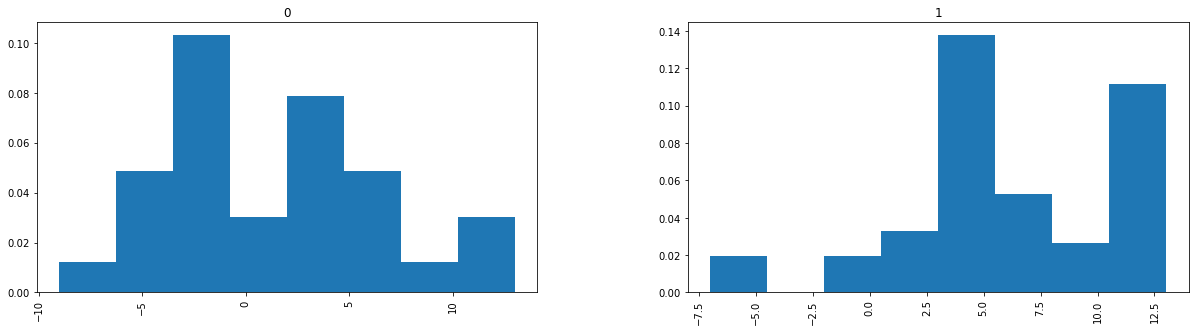

In [720]:
axList=train['score'].hist(by=train[outcome_lab],figsize=(20,5),bins=8,normed=True)

### Making predictions and performance evaluation
We will use different cutoffs and make predictions using these using the test set

Let's create a new dataframe only with the columns we are interested in:

In [721]:
scoreDF=test.iloc[:,[outcome_ix,24]]

In [722]:
def predictOutcome(row, cutoff):
    pred=None
    if row['score'] >cutoff:
        pred=1
    else:
        pred=0
    return pred

In [723]:
scoreDF['predict']=scoreDF.apply(predictOutcome,axis=1,cutoff=7)

/Users/ernesto/bin/anaconda/envs/python3/lib/python3.5/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


* Performance evaluation

In [724]:
(tn, fp, fn, tp)=confusion_matrix(scoreDF['ext_outcome'], scoreDF['predict']).ravel()
print("TP:"+str(tp))
print("TN:"+str(tn))
print("FN:"+str(fn))
print("FP:"+str(fp))

TP:13
TN:24
FN:21
FP:2


    * Precision

In [725]:
print(tp/(tp+fp))

0.866666666667


* Recall

In [726]:
print(tp/(tp+fn))

0.382352941176


### Using a Binary classifier
First, let's prepare the data by separating the data into labels (dependent variable, which is the variable we try to predict) and features (the independent variables that are going to be used for the model)

In [727]:
labels=contDF['ext_outcome']
features=contDF.drop(["ext_outcome","outcome"],axis=1)

We need also to remove some features that will be not accepted by the classifier or are not useful

In [728]:
features=features.drop(["id","start","timeframe","entry","retraced","last time","target","bounce length","space interswings"],axis=1)

ValueError: labels ['target'] not contained in axis

Now, let's split our data into training and test sets. In this case, the test_size=0.33

In [ ]:
train, test, train_labels, test_labels = train_test_split(features,
                                                          labels,
                                                          test_size=0.33,
                                                          random_state=42)

As the counts for each outcome category are unbalanced, I will oversample using SMOTE:

In [ ]:
from imblearn.over_sampling import SMOTE

train_resampled, trainlabels_resampled = SMOTE().fit_sample(train,train_labels)

Let's check the balanced counts:

In [ ]:
from collections import Counter

print(sorted(Counter(trainlabels_resampled).items()))

#### naive_bayes

Building and Evaluating the Model for the non oversampled train dataset

In [ ]:
from sklearn.naive_bayes import GaussianNB

# Initialize our classifier
gnb = GaussianNB()

# Train our classifier
model = gnb.fit(train, train_labels)

In [ ]:
# Make predictions
preds = gnb.predict(test)

In [ ]:
from sklearn.metrics import accuracy_score

# Evaluate accuracy
print(accuracy_score(test_labels, preds))

Now, with the oversampled train dataset

In [ ]:
# Train our classifier
model = gnb.fit(train_resampled,  trainlabels_resampled)

# Make predictions
preds = gnb.predict(test)

# Evaluate accuracy
print(accuracy_score(test_labels, preds))

**Conclusion** It is slightly better using oversampling

#### Using SGDClassifier
First, let's use the non oversampled train dataset

In [ ]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier()
sgd=sgd_clf.fit(train,train_labels)

In [ ]:
preds=sgd_clf.predict(test)

In [ ]:
print(accuracy_score(test_labels, preds))

Now, with the oversampled train dataset

In [ ]:
sgd_clf = SGDClassifier()
sgd=sgd_clf.fit(train_resampled,trainlabels_resampled)
preds=sgd_clf.predict(test)
print(accuracy_score(test_labels, preds))

#### Using Logistic Regression  
First, let's use the non oversampled train dataset

In [ ]:
from sklearn.linear_model import LogisticRegression
logisticRegr = LogisticRegression(verbose=1)

Now, we train the model with the training set:

In [ ]:
m=logisticRegr.fit(train, train_labels)

Now, let's measue model performance
First, we are going to make predictions using our new model and the test data

In [ ]:
predictions = logisticRegr.predict(test)

We can use the score function in order to calculate the mean accuracy on the test data and labels

In [ ]:
score = logisticRegr.score(test, test_labels)
print(score)

In order to visualize the correctness of our predictions, we can also create a confusion matrix:

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics

cm = metrics.confusion_matrix(test_labels, predictions)
print(cm)

The matrix above can be embellished by using seaborn:

In [ ]:
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".0f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 15);

Now, let's try with the oversampled train dataset

In [ ]:
from sklearn.linear_model import LogisticRegression
logisticRegr = LogisticRegression(verbose=1)

Now, we train the model with the training set:

In [ ]:
m=logisticRegr.fit(train_resampled,trainlabels_resampled)

Now, let's measue model performance
First, we are going to make predictions using our new model and the test data

In [ ]:
predictions = logisticRegr.predict(test)

We can use the score function in order to calculate the mean accuracy on the test data and labels

In [ ]:
score = logisticRegr.score(test, test_labels)
print(score)

**Conclusion:** It is worst to oversample in terms of score

* Examining the influence of each predictor on the outcome

In [ ]:
stds=np.std(train, 0)

print(stds.values*m.coef_)

In [ ]:
keys=list(train.columns)
values_10=list(stds.values*m.coef_)[0]*10

coefficients=dict(zip(keys,values_10))
print(coefficients)

**Conclusions:**  
* Relevant  
{{train.columns[0]}} (negative)  
{{train.columns[1]}} (negative)  
{{train.columns[2]}} (positive)  
{{train.columns[4]}} (negative)  
{{train.columns[5]}} (positive)  
{{train.columns[7]}} (positive)  
{{train.columns[8]}} (negative)  
{{train.columns[9]}} (negative)  
{{train.columns[10]}} (positive)  
{{train.columns[11]}} (negative)  
{{train.columns[12]}} (positive)  
{{train.columns[13]}} (negative)  
{{train.columns[14]}} (positive)  

* Irrelevant  
{{train.columns[3]}}  
{{train.columns[6]}}  
{{train.columns[15]}}